# Toy model: loss function and Bayesian sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from basic_functions_bayesian import local_density, compute_single, compute
from basic_functions_bayesian import run_Metropolis, block_analysis

## Example

In [3]:
alpha = 1

### some Dirac deltas

In [4]:
n = 2 # number of points

# probability distribution:
p0 = [3/4,1/4]

# normalize, if not normalized
p0 = p0/np.sum(p0)

# value of the observable at these points:
g = np.array([0, 1])

# experimental value and error of the observable
gexp = 0.9
sigma = 0.2

In [5]:
dlambda = 1e-1
lambdamax = 5
lambdas = np.arange(-lambdamax-dlambda, lambdamax+dlambda, dlambda)

In [6]:
out = compute_single(0.3, p0, np.array([g]), gexp, sigma, alpha)

vars(out)

{'P': array([0.80196359, 0.19803641]),
 'Z': 0.9352045551704294,
 'av_g': array([0.19803641]),
 'av_g2': array([0.19803641]),
 'var_g': array([0.15881799]),
 'std_g': array([0.39851975]),
 'chi2': array([12.31882195]),
 'Srel': -0.0075790742524419474,
 'lossf': 6.166990049371298,
 'gamma': array([0.20481]),
 'jeffreys': 0.39851975094804726,
 'dirichlet': 0.1980364126184974,
 'avg_density': 0.15881799189569362}

In [7]:
results = compute(lambdas, p0, g, gexp, sigma, alpha)

ValueError: non-broadcastable output operand with shape (2,) doesn't match the broadcast shape (1,2)

In [23]:
results

{'P': array([[0.01796172, 0.98203828],
        [0.01981334, 0.98018666],
        [0.02185159, 0.97814841],
        [0.02409437, 0.97590563],
        [0.02656109, 0.97343891],
        [0.02927277, 0.97072723],
        [0.03225212, 0.96774788],
        [0.03552361, 0.96447639],
        [0.03911353, 0.96088647],
        [0.04305005, 0.95694995],
        [0.04736322, 0.95263678],
        [0.05208501, 0.94791499],
        [0.05724923, 0.94275077],
        [0.06289152, 0.93710848],
        [0.06904916, 0.93095084],
        [0.07576095, 0.92423905],
        [0.08306694, 0.91693306],
        [0.0910081 , 0.9089919 ],
        [0.09962594, 0.90037406],
        [0.10896202, 0.89103798],
        [0.1190573 , 0.8809427 ],
        [0.12995149, 0.87004851],
        [0.14168222, 0.85831778],
        [0.15428411, 0.84571589],
        [0.16778775, 0.83221225],
        [0.18221864, 0.81778136],
        [0.19759599, 0.80240401],
        [0.21393156, 0.78606844],
        [0.23122844, 0.76877156],
        [

### or more Dirac deltas, so random generation of values

In [11]:
n = 200  # n. frames

#g=np.concatenate((np.random.normal(0,size=np.int(N/2)),np.random.normal(1,size=np.int(N/2))))
x = np.random.normal(1, 0.5, size=n)

# g = x
g = x**2
# g = 1/x**2

gexp = 2
sigma = 0.5

p0 = np.random.dirichlet(np.ones(n), size=1)[:, 0]

lambdamax = 10

dlambda = 0.01
# lambdas = np.arange(- lambdamax - dlambda, lambdamax + dlambda, dlambda)

lambdas = np.linspace(-lambdamax, lambdamax, n)

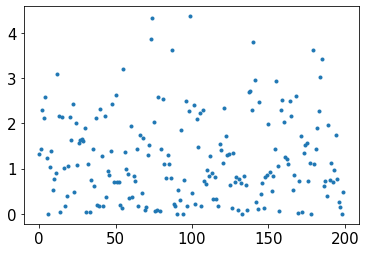

In [12]:
plt.plot(g, '.')

In [13]:
results = compute(lambdas, p0, g, gexp, sigma, alpha)

Text(0.5, 0, 'n frames')

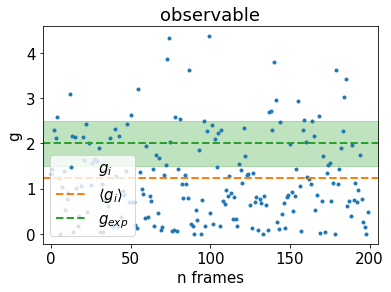

In [14]:
plt.plot(g, '.', label=r'$g_i$')

plt.plot([-5, len(g) + 5], [np.mean(g), np.mean(g)], '--', label=r'$\langle g_i\rangle$')  # ,color='tab:blue')

plt.plot([-5, len(g) + 5], [gexp, gexp], '--', label=r'$g_{exp}$')
plt.fill_between([-5, len(g) + 5], [gexp - sigma, gexp - sigma], [gexp + sigma, gexp + sigma], alpha=0.3, color='tab:green')

plt.title('observable')
plt.legend(loc='lower left')
plt.xlim([-5, len(g) + 5])
plt.ylabel('g')
plt.xlabel('n frames')

### more observables

In [9]:
# probability distribution:
p0 = [3, 4, 1, 1]

# normalize, if not normalized
p0 = p0/np.sum(p0)

# value of the observable at these points:
g = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]).T

# experimental value and error of the observable
gexp = [0.1, 0.8]
sigma = [0.2, 0.1]

print(p0.shape, g.shape)

(4,) (2, 4)


In [10]:
var = 0.1/1  # spread of the 4 peaks (assumption: the same for all)
how_many = 50  # times prop, it gives the population of the 4 peaks
prop = [1, 1, 1, 1]  # chosen proportion of the 4 peaks

g = np.concatenate((np.random.multivariate_normal(mean=(0, 0), cov=var*np.diag([1, 1]), size=prop[0]*how_many),
    np.random.multivariate_normal(mean=(0, 1), cov=var*np.diag([1, 1]), size=prop[1]*how_many),
    np.random.multivariate_normal(mean=(1, 0), cov=var*np.diag([1, 1]), size=prop[2]*how_many),
    np.random.multivariate_normal(mean=(1, 1), cov=var*np.diag([1, 1]), size=prop[3]*how_many))).T

p0 = np.ones(len(g.T))  # different n. of points in each Gaussian
p0 = p0/np.sum(p0)

print(p0.shape, g.shape)

(200,) (2, 200)


In [11]:
lambda_i = [1, 1]

out = compute_single(lambda_i, p0, g, gexp, sigma, alpha)

vars(out)

{'P': array([0.03522307, 0.02021455, 0.01799892, 0.00460561, 0.0134222 ,
        0.00532044, 0.00543535, 0.01346342, 0.00701381, 0.01291777,
        0.01194313, 0.0184818 , 0.00624428, 0.00398934, 0.00906517,
        0.00658545, 0.00797301, 0.01164102, 0.01532783, 0.00699418,
        0.00451242, 0.01285096, 0.00544993, 0.02914066, 0.010888  ,
        0.00455481, 0.00635668, 0.00943852, 0.01051844, 0.01094085,
        0.00549024, 0.02628702, 0.00768183, 0.00950591, 0.0051356 ,
        0.00705461, 0.00457396, 0.00582516, 0.01380489, 0.01222281,
        0.00509256, 0.00715242, 0.01209275, 0.00774145, 0.0108215 ,
        0.00586621, 0.0106045 , 0.01751428, 0.00858866, 0.01148862,
        0.00152881, 0.00231833, 0.00315634, 0.00380986, 0.0030094 ,
        0.00324844, 0.00412389, 0.00466531, 0.00207076, 0.00503278,
        0.00246239, 0.00309693, 0.0058106 , 0.00539319, 0.00358736,
        0.00216856, 0.00419953, 0.00322685, 0.00240972, 0.00370398,
        0.0030925 , 0.00678438, 0.00237528,

In [12]:
lambdas = np.linspace(-30, 30, 100)

my_grid = np.meshgrid(lambdas, lambdas)

out = {}

for l1 in lambdas:
    out[l1] = {}
    for l2 in lambdas:
        out[l1][l2] = vars(compute_single(np.array([l1, l2]), p0, g, gexp, sigma, alpha))
        out[l1][l2]['jeffreys'] = compute_sqrt_det(g.T, out[l1][l2]['P'])[0]

/tmp/ipykernel_20985/45840108.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lambdas, lambdas, -np.log(jeff), cmap='jet')
/tmp/ipykernel_20985/45840108.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lambdas, lambdas, loss, cmap='jet')
/tmp/ipykernel_20985/45840108.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the q

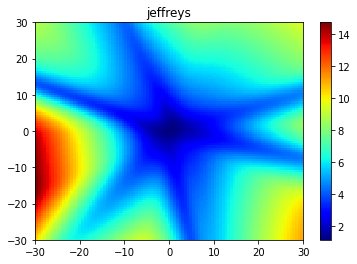

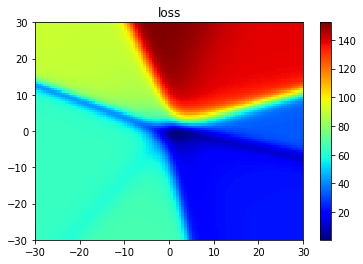

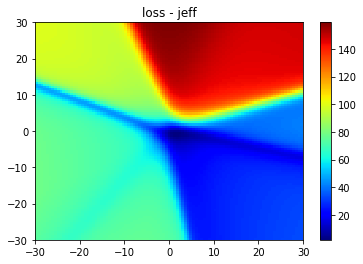

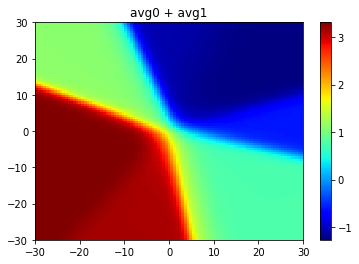

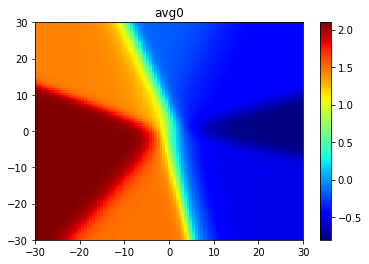

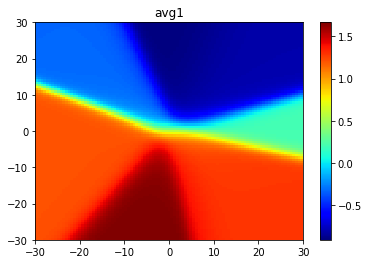

In [13]:
loss = [[out[l1][l2]['lossf'] for l1 in lambdas] for l2 in lambdas]
jeff = [[out[l1][l2]['jeffreys'] for l1 in lambdas] for l2 in lambdas]
avg0 = np.array([[out[l1][l2]['av_g'][0] for l1 in lambdas] for l2 in lambdas])
avg1 = np.array([[out[l1][l2]['av_g'][1] for l1 in lambdas] for l2 in lambdas])

# plt.imshow(lambdas, lambdas, loss, 'jet')
# plt.pcolormesh(lambdas, lambdas, loss, cmap='jet')
plt.pcolormesh(lambdas, lambdas, -np.log(jeff), cmap='jet')
plt.title('jeffreys')
plt.colorbar()

plt.figure()
plt.title('loss')
plt.pcolormesh(lambdas, lambdas, loss, cmap='jet')
plt.colorbar()

plt.figure()
plt.title('loss - jeff')
plt.pcolormesh(lambdas, lambdas, loss - np.log(jeff), cmap='jet')
plt.colorbar()

plt.figure()
plt.title('avg0 + avg1')
plt.pcolormesh(lambdas, lambdas, avg0 + avg1, cmap='jet')
plt.colorbar()

plt.figure()
plt.title('avg0')
plt.pcolormesh(lambdas, lambdas, avg0, cmap='jet')
plt.colorbar()

plt.figure()
plt.title('avg1')
plt.pcolormesh(lambdas, lambdas, avg1, cmap='jet')
plt.colorbar()
plt.show()

In [196]:
lambdas0 = np.zeros(2)

def proposal(x0, dx=0.01):
    x_new = x0 + dx*np.random.normal(size=len(x0))
    return x_new

proposal_full = {'fun': proposal, 'args': ([0.5])}

def energy_fun(lambdas, if_Jeffreys):
    
    out = compute_single(lambdas, p0, g, gexp, sigma, alpha)
    
    energy = out.lossf

    av_g = out.av_g

    if if_Jeffreys:
        measure = compute_sqrt_det(g.T, out.P)[0]
        energy -= np.log(measure)
    
    return energy, av_g

In [197]:
energy_function = {'fun': energy_fun, 'args': ([True])}
out_J = run_Metropolis(lambdas0, proposal_full, energy_function, n_steps=10000)

energy_function = {'fun': energy_fun, 'args': ([False])}
out_noJ = run_Metropolis(lambdas0, proposal_full, energy_function, n_steps=10000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [198]:
print('acceptance: ', out_J[-1], out_noJ[-1])

acceptance:  0.4917 0.4983


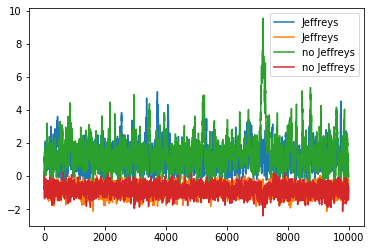

In [199]:
plt.plot(out_J[0], label='Jeffreys')
plt.plot(out_noJ[0], label='no Jeffreys')
plt.legend()

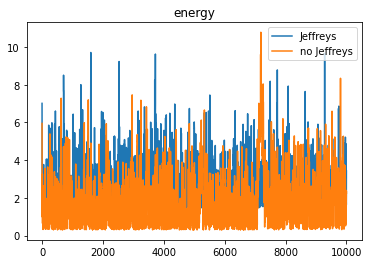

In [200]:
plt.plot(out_J[1], label='Jeffreys')
plt.plot(out_noJ[1], label='no Jeffreys')
plt.title('energy')
plt.legend()

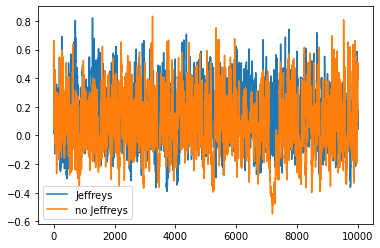

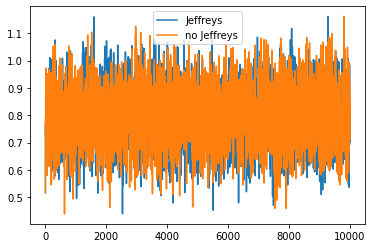

In [201]:
plt.plot(out_J[2][:, 0], label='Jeffreys')
plt.plot(out_noJ[2][:, 0], label='no Jeffreys')
plt.legend()

plt.figure()
plt.plot(out_J[2][:, 1], label='Jeffreys')
plt.plot(out_noJ[2][:, 1], label='no Jeffreys')
plt.legend()

In [202]:
av_J = np.mean(out_J[2], axis=0)
av_noJ = np.mean(out_noJ[2], axis=0)

print(av_J, av_noJ)

# here you should use block analysis
std_J = np.std(out_J[2], axis=0)/np.sqrt(len(out_J[2]))
std_noJ = np.std(out_noJ[2], axis=0)/np.sqrt(len(out_noJ[2]))

print(std_J, std_noJ)

order_par = (np.sum((av_J - av_noJ)**2/(std_J**2 + std_noJ**2)))
print(order_par)

[0.13264458 0.79326846] [0.07225841 0.79975329]
[0.00194404 0.00100318] [0.00210302 0.00100762]
465.38935283172015


## compute and plot

In [55]:
results = compute(lambdas, p0, g, gexp, sigma, alpha)

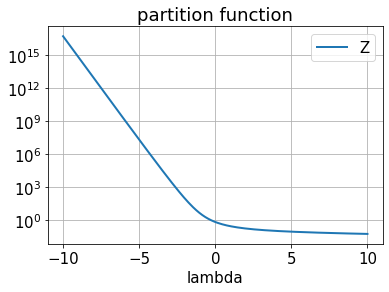

In [15]:
plt.plot(lambdas, results['Z'], '-', label='Z')
plt.yscale('log')
plt.xlabel('lambda')
plt.title('partition function')
plt.legend()
plt.grid()

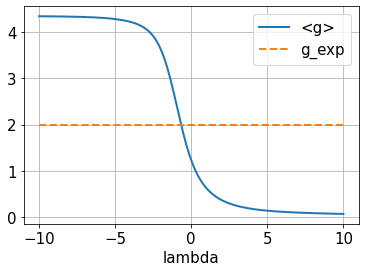

In [16]:
plt.plot(lambdas, results['av_g'], '-', label='<g>')
plt.plot([lambdas[0], lambdas[-1]], [gexp, gexp], '--', label='g_exp')
#plt.yscale('log')
plt.xlabel('lambda')
plt.legend()
plt.grid()

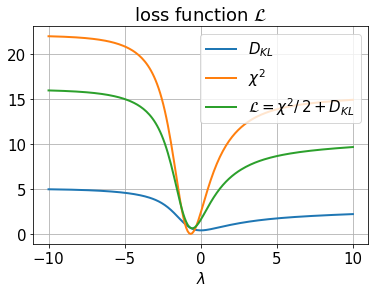

In [19]:
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 2

plt.plot(lambdas, -results['Srel'], '-', label=r'$D_{KL}$')
plt.plot(lambdas, results['chi2'], '-', label=r'$\chi^2$')
plt.plot(lambdas, -results['Srel'] + 1/2*results['chi2'], '-', label=r'$\mathcal{L}=\chi^2/\,2+D_{KL}$')

plt.title(r'loss function $\mathcal{L}$')
#plt.yscale('log')
# plt.xlim([-50, 50])
plt.xlabel(r'$\lambda$')
plt.legend()
plt.grid()


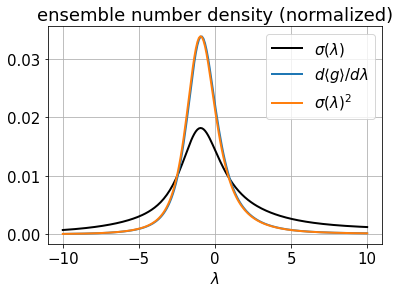

In [21]:
#plt.plot(lambdas,-np.log(std_gs),'-',label='- log std')

normalize = lambda x: x/np.sum(x)

plt.plot(lambdas, normalize(results['std_g']), '-', label=r'$\sigma(\lambda)$', c='k')
#plt.plot(lambdas,-2*np.log(std_gs),'-',label='- log variance')
#plt.plot(lambdas,-np.log(dirichlets),'-',label='equiv. for Dirichlet')

plt.plot(lambdas[1:], normalize(np.abs(np.ediff1d(results['av_g'])/np.ediff1d(lambdas))), '-', label=r'$d\langle g\rangle/d\lambda$')
plt.plot(lambdas, normalize(results['std_g']**2), '-', label=r'$\sigma(\lambda)^2$')

plt.xlabel(r'$\lambda$')
plt.grid()
plt.legend()
#plt.title('volume transformation')
# plt.xlim([-30, 30])
plt.title('ensemble number density (normalized)')
plt.show()

So we could say it is quite the same to use $\sigma d\lambda$ or $\sigma^2 d\lambda$, corresponding to measuring distances with Fisher metrics (namely, Jeffreys prior, KL divergence) or with $d\langle g \rangle$, respectively. However, there is the issue of dimensions: are there more ensembles in between 1 and 2 $\mu m$ or in between 1 and 2 $Hz$? It makes no sense, so let's use $\sigma d\lambda$ which is adimensional.

In [119]:
results['lossf']

array([ 2.9108997 ,  2.90919951,  2.90750413,  2.90581487,  2.90413306,
        2.90246011,  2.90079746,  2.89914662,  2.89750912,  2.89588653,
        2.89428047,  2.89269255,  2.89112438,  2.8895775 ,  2.88805337,
        2.88655321,  2.8850779 ,  2.88362772,  2.88220205,  2.88079875,
        2.87941339,  2.87803795,  2.87665877,  2.87525352,  2.87378637,
        2.87220041,  2.87040571,  2.86825991,  2.86553592,  2.86186592,
        2.85663824,  2.84879298,  2.83637997,  2.81551349,  2.7777069 ,
        2.7027511 ,  2.53981437,  2.16480735,  1.39750088,  1.07642515,
        3.41714112,  7.31743572,  9.58884729, 10.42574738, 10.80015407,
       11.02145201, 11.1720393 , 11.28014915, 11.35958782, 11.41894159,
       11.46411979, 11.49931693, 11.52752572, 11.55087528, 11.57087278,
       11.58857908, 11.60473629, 11.61985965, 11.6343035 , 11.64830827,
       11.66203402, 11.67558426, 11.68902287, 11.7023861 , 11.71569118,
       11.72894234, 11.74213511, 11.75525941, 11.76830172, 11.78

In [22]:
loss = results['lossf']
loss -= np.min(loss)

loss1 = loss - np.log(results['std_g'])
loss1 -= np.min(loss1)

loss2 = loss - 2*np.log(results['std_g'])
loss2 -= np.min(loss2)

gamma = results['gamma']

loss_dir = loss - np.log(results['dirichlet'])

delta = np.min(loss) - np.min(gamma)

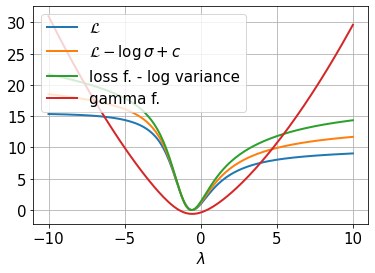

In [24]:
plt.plot(lambdas, loss, '-', label=r'$\mathcal{L}$')#loss f.')#,markersize=0.5)
plt.plot(lambdas, loss1, '-', label=r'$\mathcal{L}-\log\sigma+c$')
#plt.plot(lambdas,-loss+loss1,'-',label=r'$-\log\sigma$')

plt.plot(lambdas, loss2, '-', label='loss f. - log variance')
plt.plot(lambdas, gamma, '-', label='gamma f.')
#plt.plot(lambdas,gamma+delta,'-',label='gamma f. +delta')
#plt.plot(lambdas,loss_dir,'-',label='loss f. with Dirichlet correction')

plt.legend(loc='upper left')#(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$\lambda$')
#plt.yscale('log')
# plt.xlim([-30, 30])
# plt.ylim([-5,40])
plt.grid()

In [25]:
xmin_loss = lambdas[np.argwhere(loss == np.min(loss))[0][0]]
xmin_gamma = lambdas[np.argwhere(gamma == np.min(gamma))[0][0]]
xmin_1 = lambdas[np.argwhere(loss1 == np.min(loss1))[0][0]]
xmin_2 = lambdas[np.argwhere(loss2 == np.min(loss2))[0][0]]

print('min. of the "original" loss function: ', xmin_loss)
print('min. of Gamma function: ', xmin_gamma)
print('min. of the loss f. with std correction: ', xmin_1)
print('min. of the loss f. with variance correction: ', xmin_2)


min. of the "original" loss function:  -0.5527638190954764
min. of Gamma function:  -0.5527638190954764
min. of the loss f. with std correction:  -0.5527638190954764
min. of the loss f. with variance correction:  -0.6532663316582905


so, the hyper probability distribution $P(\lambda)$ is:

In [26]:
hyper_P0 = np.exp(-loss)
hyper_P1 = np.exp(-loss1)
hyper_P2 = np.exp(-loss2)
hyper_P_gamma = np.exp(-gamma)
hyper_P_dir = np.exp(-loss_dir)

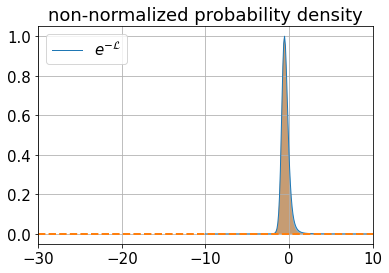

In [27]:
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['font.size'] = 15

plt.plot(lambdas, hyper_P0, label=r'$e^{-\mathcal{L}}$')
plt.fill_between(lambdas, np.zeros(len(lambdas)), hyper_P0, alpha=0.5)
#plt.plot(lambdas,hyper_P_gamma,label='gamma')

#plt.plot(lambdas,hyper_P1,label=r'$\sigma \, e^{-\mathcal{L}}$')
plt.fill_between(lambdas, np.zeros(len(lambdas)), hyper_P1, alpha=0.5)

#plt.plot(lambdas,hyper_P2,label='original with variance correction')
#plt.plot(lambdas,hyper_P_dir,label='original with Dirichlet correction')
plt.xlim([-30, 10])
plt.plot([-30, 10], [hyper_P0[0], hyper_P0[0]], '--', linewidth=2)
#plt.yscale('log')
plt.grid()
plt.title('non-normalized probability density')
plt.legend(loc='upper left')#(loc='center left', bbox_to_anchor=(1, 0.5))

In [28]:
hyper_P0 = hyper_P0/np.sum(hyper_P0)
hyper_P1 = hyper_P1/np.sum(hyper_P1)
hyper_P2 = hyper_P2/np.sum(hyper_P2)
hyper_P_gamma = hyper_P_gamma/np.sum(hyper_P_gamma)
hyper_P_dir = hyper_P_dir/np.sum(hyper_P_dir)

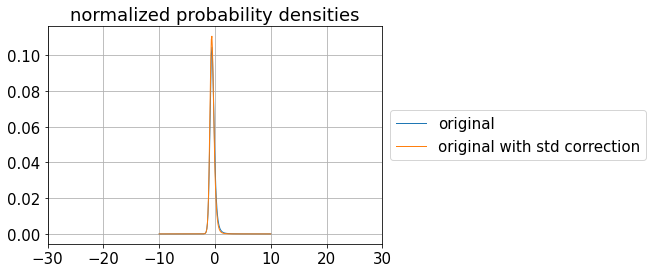

In [29]:
plt.plot(lambdas, hyper_P0, label='original')
#plt.plot(lambdas,hyper_P_gamma,label='gamma')
plt.plot(lambdas, hyper_P1, label='original with std correction')
#plt.plot(lambdas,hyper_P2,label='original with variance correction')
#plt.plot(lambdas,hyper_P_dir,label='original with Dirichlet correction')
plt.xlim([-30, 30])
#plt.yscale('log')
plt.grid()
plt.title('normalized probability densities')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Metropolis sampling

In [23]:
# choice=0 Jeffreys, 1 BELT, 2 BELT modified (averages)
def Metropolis_sampling(delta=0.5,nsteps=100,phi0=0,choice=0): # z0=1

    #rng=np.random.default_rng(seed=0)

    traj=[]
    time=[]
    avaccept=0
    energies=[]

    #phi=minphis+np.random.normal(minphis,1,size=1)*z0
    phi=phi0

    traj.append(phi)
    time.append(0)

    out=compute_single(phi,P0,g,gexp,sigma,alpha)
    
    #out=-np.exp(-phi**2) # sample a gaussian-like (i.e. with minimum but not bounded) potential
    if choice==0: energy=out[6]-np.log(out[3])
    elif choice==1: energy=out[6]
    elif choice==2: energy=out[6]-2*np.log(out[3])

    energies.append(energy)

    for istep in range(nsteps):
        #delta=0.1
        # better, different deltas for different coordinates, estimated with the covariance at MAP
        #delta=0.1*np.sqrt(np.diag(goodcov))
        #phitry=trial(phi,delta=delta)
        phitry=phi+(2*np.random.rand()-1)*delta

        
        out=compute_single(phitry,P0,g,gexp,sigma,alpha)
        if choice==0: energy_try=out[6]-np.log(out[3])
        elif choice==1: energy_try=out[6]
        elif choice==2: energy_try=out[6]-2*np.log(out[3])
        #print(lossf_try)

        accept=np.exp(energy-energy_try)
        
        if accept>1: accept=1
        if accept>np.random.rand():
            avaccept+=1
            phi=+phitry
            energy=+energy_try

        traj.append(phi)
        time.append(istep+1)
        energies.append(energy)

    avaccept=avaccept/nsteps
    

    return np.array(time),np.array(traj),avaccept,energies




In [101]:
time,traj,avalpha,lossf=Metropolis_sampling(nsteps=1000000,phi0=0,choice=0) # JEFFREYS

In [102]:
time2,traj2,avalpha2,lossf2=Metropolis_sampling(nsteps=1000000,phi0=0,choice=1) # BELT

/tmp/ipykernel_3217/1671233481.py:9: RuntimeWarning: invalid value encountered in sqrt
  std_g=np.sqrt(av_g2-av_g**2)


In [ ]:
time3,traj3,avalpha3,lossf3=Metropolis_sampling(nsteps=1000000,phi0=0,choice=2) # BELT 2 (averages)

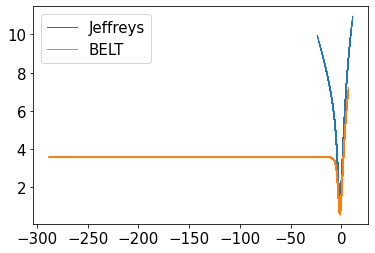

In [103]:
upto=1000000
plt.plot(traj[:upto],lossf[:upto],'-',label='Jeffreys')
plt.plot(traj2[:upto],lossf2[:upto],'-',label='BELT')
#plt.plot(traj3,lossf3,'-',label='BELT 2 (averages)')

plt.legend()

(0.0, 1000000.0)

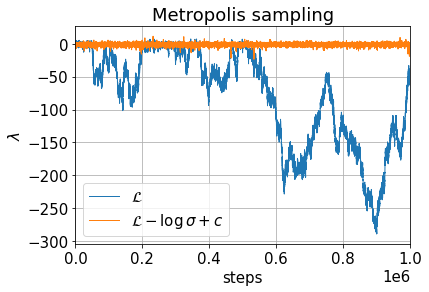

In [108]:
plt.rcParams['font.size']=15

plt.plot(time2[:upto],traj2[:upto],'-',label=r'$\mathcal{L}$',linewidth=1) # label='BELT' r'$dn=d\lambda$'
plt.plot(time[:upto],traj[:upto],'-',label=r'$\mathcal{L}-\log\sigma+c$',linewidth=1) # label='with Jeffreys prior" r'$dn=\sigma (\lambda) \, d\lambda$'

#plt.plot(time3,traj3,'-',label='BELT 2 (averages)')

plt.grid()
plt.legend(loc='lower left')
plt.title('Metropolis sampling')
plt.xlabel('steps')
plt.ylabel(r'$\lambda$')
#plt.ylim([-10,5])
plt.xlim([0,upto])

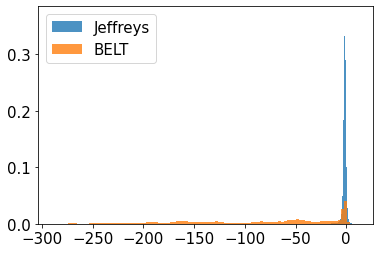

In [105]:
plt.hist(traj,bins=100,alpha=0.8,density=True,label='Jeffreys')

#plt.figure()
plt.hist(traj2,bins=100,alpha=0.8,density=True,label='BELT')
#plt.hist(traj3,bins=100)

plt.legend()

## Giovanni's trials:
- invariance w.r.t. number of frames
- data incompatible with trajectory

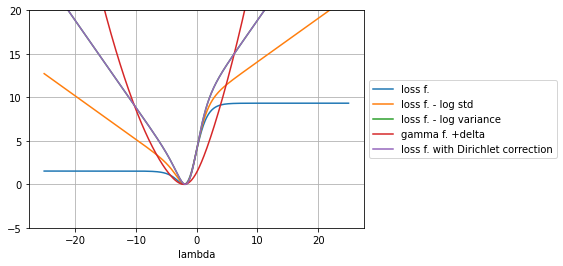

In [10]:
N=1
P0=np.array([3.]*N + [1.]*N)
P0/=np.sum(P0)
g=np.array([0]*N + [1]*N)

gexp=0.9



[Ps, Zs, av_gs, std_gs, dirichlets, chi2, Srel, loss, gamma]=compute(lambdas,P0,g,gexp,sigma,alpha)

loss=np.array(loss)
loss1=loss-np.log(std_gs)
loss2=loss-2*np.log(std_gs)
gamma=np.array(gamma)
loss_dir=loss-np.log(dirichlets)

loss-=np.min(loss)
loss1-=np.min(loss1)
loss2-=np.min(loss2)
gamma-=np.min(gamma)
loss_dir-=np.min(loss_dir)

plt.plot(lambdas,loss,'-',label='loss f.')#,markersize=0.5)
plt.plot(lambdas,loss1,'-',label='loss f. - log std')
plt.plot(lambdas,loss2,'-',label='loss f. - log variance')
#plt.plot(lambdas,gamma,'-',label='gamma f.')
plt.plot(lambdas,gamma,'-',label='gamma f. +delta')
plt.plot(lambdas,loss_dir,'-',label='loss f. with Dirichlet correction')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('lambda')
#plt.yscale('log')
#plt.xlim([-10,10])
plt.ylim([-5,20])
plt.grid()

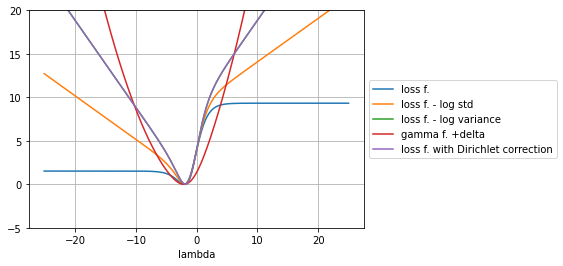

In [11]:
# invariance wrt number of frames:
N=1000
P0=np.array([3.]*N + [1.]*N)
P0/=np.sum(P0)
g=np.array([0]*N + [1]*N)

gexp=0.9



[Ps, Zs, av_gs, std_gs, dirichlets, chi2, Srel, loss, gamma]=compute(lambdas,P0,g,gexp,sigma,alpha)

loss=np.array(loss)
loss1=loss-np.log(std_gs)
loss2=loss-2*np.log(std_gs)
gamma=np.array(gamma)
loss_dir=loss-np.log(dirichlets)

loss-=np.min(loss)
loss1-=np.min(loss1)
loss2-=np.min(loss2)
gamma-=np.min(gamma)
loss_dir-=np.min(loss_dir)

plt.plot(lambdas,loss,'-',label='loss f.')#,markersize=0.5)
plt.plot(lambdas,loss1,'-',label='loss f. - log std')
plt.plot(lambdas,loss2,'-',label='loss f. - log variance')
#plt.plot(lambdas,gamma,'-',label='gamma f.')
plt.plot(lambdas,gamma,'-',label='gamma f. +delta')
plt.plot(lambdas,loss_dir,'-',label='loss f. with Dirichlet correction')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('lambda')
#plt.yscale('log')
#plt.xlim([-10,10])
plt.ylim([-5,20])
plt.grid()

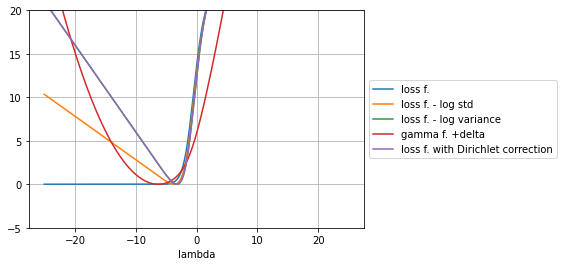

In [20]:
# data incompatible with trajectory
N=1
P0=np.array([3.]*N + [1.]*N)
P0/=np.sum(P0)
g=np.array([0]*N + [1]*N)

gexp=1.5



[Ps, Zs, av_gs, std_gs, dirichlets, chi2, Srel, loss, gamma]=compute(lambdas,P0,g,gexp,sigma,alpha)

loss=np.array(loss)
loss1=loss-np.log(std_gs)
loss2=loss-2*np.log(std_gs)
gamma=np.array(gamma)
loss_dir=loss-np.log(dirichlets)

loss-=np.min(loss)
loss1-=np.min(loss1)
loss2-=np.min(loss2)
gamma-=np.min(gamma)
loss_dir-=np.min(loss_dir)



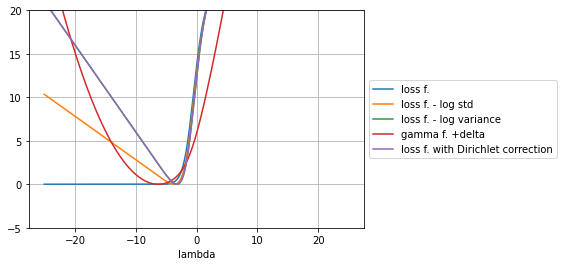

In [23]:
plt.plot(lambdas,loss,'-',label='loss f.')#,markersize=0.5)
plt.plot(lambdas,loss1,'-',label='loss f. - log std')
plt.plot(lambdas,loss2,'-',label='loss f. - log variance')
#plt.plot(lambdas,gamma,'-',label='gamma f.')
plt.plot(lambdas,gamma,'-',label='gamma f. +delta')
plt.plot(lambdas,loss_dir,'-',label='loss f. with Dirichlet correction')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('lambda')
#plt.yscale('log')
#plt.xlim([-10,10])
plt.ylim([-5,20])
plt.grid()

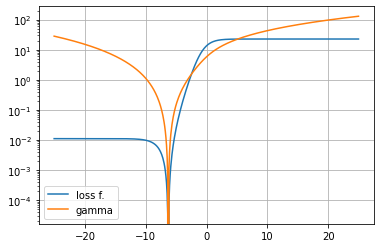

In [29]:
plt.plot(lambdas,loss,label='loss f.')
plt.plot(lambdas,gamma,label='gamma')
plt.yscale('log')
plt.legend()
plt.grid()


In [21]:
xmin_loss=lambdas[np.argwhere(loss==np.min(loss))[0][0]]
xmin_gamma=lambdas[np.argwhere(gamma==np.min(gamma))[0][0]]
xmin_1=lambdas[np.argwhere(loss1==np.min(loss1))[0][0]]
xmin_2=lambdas[np.argwhere(loss2==np.min(loss2))[0][0]]

print('min. of the "original" loss function: ', xmin_loss)
print('min. of Gamma function: ',xmin_gamma)
print('min. of the loss f. with std correction: ', xmin_1)
print('min. of the loss f. with variance correction: ', xmin_2)

min. of the "original" loss function:  -6.299999999999734
min. of Gamma function:  -6.299999999999734
min. of the loss f. with std correction:  -3.6999999999996973
min. of the loss f. with variance correction:  -3.2999999999996916


### coarse graining

In [50]:

P0s=[np.array([1/3, 2/3]),np.array([1/3, 1/3, 1/3]),np.array([1/3, 0, 2/3])] # normalized
g2p=np.array([1,2])
g3p=np.array([1,2,2])
gs=[g2p,g3p,g3p]

gexp=0.9

In [51]:
Srels=[]
for i in range(len(P0s)):
    Srels.append(compute(lambdas,P0s[i],gs[i],gexp,sigma,alpha)[6])

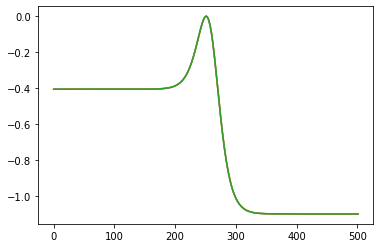

In [52]:
for Srel in Srels:
    plt.plot(Srel,'-')